# Tema 6 IDS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import math

print(f'\tCurrent Numpy version: {np.__version__}')
print('\tNumpy version at the creation of the project: 1.20.2')

print(f'\n \tCurrent Pandas version: {pd.__version__}')
print('\tPandas version at the creation of the project: 1.2.4')

print(f'\n \tCurrent Regular Expressions version: {re.__version__}')
print('\tRegular Expressions version at the creation of the project: 2.2.1')

print(f'\n \tCurrent Seaborn version: {sns.__version__}')
print('\tSeaborn version at the creation of the project: 0.11.1')

	Current Numpy version: 1.20.2
	Numpy version at the creation of the project: 1.20.2

 	Current Pandas version: 1.2.4
	Pandas version at the creation of the project: 1.2.4

 	Current Regular Expressions version: 2.2.1
	Regular Expressions version at the creation of the project: 2.2.1

 	Current Seaborn version: 0.11.1
	Seaborn version at the creation of the project: 0.11.1


In [2]:
!pip install nltk

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Laur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

## Setul de date `SMSSpamCollection`

### Descrierea setului de date

Setul de date `SMSSpamCollection` este un set de mesaje SMS care au fost colectate pentru a analiza SMS-urile de tip Spam. Acesta contine un set de 5574 mesaje text in limba engleza clasificate in 2 categorii: `ham`(mesaje legitime) sau `spam`.

Aceste mesaje au fost colectate din resurse gratuite de pe Web:
* O colectie de aproximativ 425 SMS-uri de tip spam extrase manual de pe site-ul [Grumbletext](http://www.grumbletext.co.uk). Acesta este un forum din UK in care utilizatorii telefoanelor mobile fac plangeri publice despre mesajele text de tip spam.
* O lista de 450 de SMS-uri legitime colectate din [teza de doctorat a lui Caroline Tag](http://etheses.bham.ac.uk/253/1/Tagg09PhD.pdf).
* Un subset de 3375 mesaje legitime luate de pe site-ul [NUS SMS Corpus (NSC)](http://www.comp.nus.edu.sg/~rpnlpir/downloads/corpora/smsCorpus/), un site care contine aproximativ 10000 de mesaje SMS legitime colectate pentru research de catre Department of Computer Science at the National University of Singapore. Mesajele provin in mare parte de la oamenii din Singapore si de la studentii de la universitate. Aceste mesaje au fost colectate de voluntari.
* Un numar de 1002 SMS-uri legitime si 332 SMS-uri de tip spam extrase din [SMS Spam Corpus v.0.1 Big](http://www.esp.uem.es/jmgomez/smsspamcorpus/), colectie creata de José María Gómez Hidalgo.

Setul de date contine un total de 4827 de SMS-uri de tip legitim (86.6%) si 747 de mesaje de tip spam (13.4%).

### Analiza exploratorie a setului de date

In [5]:
data = pd.read_csv("data/SMSSpamCollection", delimiter="\t", header=None)
data = data.rename(columns= {0: 'Class', 1:'Message'})

In [6]:
data.head()

,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Vom exemplifica acum cum arata un `mesaj legitim`

In [7]:
data[data['Class'] == 'ham'].iloc[0]['Message']

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

Vom da un exemplu si de mesaj de tip `spam`

In [8]:
data[data['Class'] == 'spam'].iloc[0]['Message']

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

Verificam daca exista vreo valoare NaN in setul nostru de date

In [9]:
data.isna().sum()

Class      0
Message    0
dtype: int64

Vom creea etichete numerice pentru clasificare

In [10]:
label = {'ham': 0, 'spam': 1}
data['IsSpam'] = data['Class'].map(label)
data

,Class,Message,IsSpam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1
5568,ham,Will ü b going to esplanade fr home?,0
5569,ham,"Pity, * was in mood for that. So...any other s...",0
5570,ham,The guy did some bitching but I acted like i'd...,0


Pentru standardizarea tuturor mesajelor, vom face toate literele de tip lowercase

In [11]:
data['Message'] = data['Message'].str.lower()
data['Message']

0       go until jurong point, crazy.. available only ...
1                           ok lar... joking wif u oni...
2       free entry in 2 a wkly comp to win fa cup fina...
3       u dun say so early hor... u c already then say...
4       nah i don't think he goes to usf, he lives aro...
                              ...                        
5567    this is the 2nd time we have tried 2 contact u...
5568                 will ü b going to esplanade fr home?
5569    pity, * was in mood for that. so...any other s...
5570    the guy did some bitching but i acted like i'd...
5571                           rofl. its true to its name
Name: Message, Length: 5572, dtype: object

Calculam lungimea mesajelor si adaugam o coloana cu aceasta valoare in dataframe-ul nostru

In [12]:
data['Length'] = data['Message'].apply(len)
data

,Class,Message,IsSpam,Length
0,ham,"go until jurong point, crazy.. available only ...",0,111
1,ham,ok lar... joking wif u oni...,0,29
2,spam,free entry in 2 a wkly comp to win fa cup fina...,1,155
3,ham,u dun say so early hor... u c already then say...,0,49
4,ham,"nah i don't think he goes to usf, he lives aro...",0,61
...,...,...,...,...
5567,spam,this is the 2nd time we have tried 2 contact u...,1,160
5568,ham,will ü b going to esplanade fr home?,0,36
5569,ham,"pity, * was in mood for that. so...any other s...",0,57
5570,ham,the guy did some bitching but i acted like i'd...,0,125


In [13]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

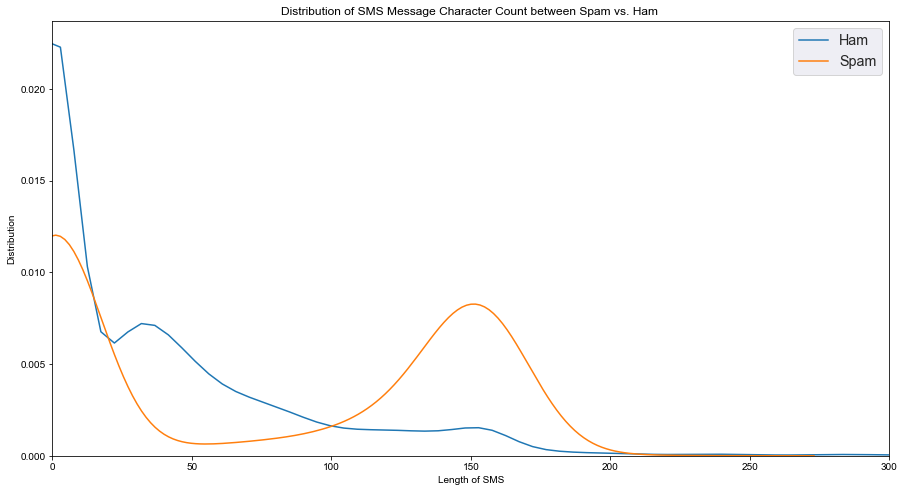

In [14]:
plt.figure(figsize=(15, 8))
hams_length = data[data['IsSpam'] == 0][['IsSpam', 'Length']]
spam_length = data[data['IsSpam'] == 1][['IsSpam', 'Length']]
ax = sns.distplot(hams_length, hist = False, label = 'Ham')
ax = sns.distplot(spam_length, hist = False, label = 'Spam')
plt.xlim(0, 300)
plt.title('Distribution of SMS Message Character Count between Spam vs. Ham ')
sns.set(font_scale=1.3)
plt.legend()
ax.set_ylabel('Distribution')
ax.set_xlabel('Length of SMS');

Afisam date despre mesajele legitime.

In [15]:
data[data['IsSpam'] == 0].describe()

,IsSpam,Length
count,4825.0,4825.000000
mean,0.0,71.482487
std,0.0,58.440652
min,0.0,2.000000
25%,0.0,33.000000
50%,0.0,52.000000
75%,0.0,93.000000
max,0.0,910.000000


Afisam date despre mesajele de tip spam.

In [16]:
data[data['IsSpam'] == 1].describe()

,IsSpam,Length
count,747.0,747.000000
mean,1.0,138.670683
std,0.0,28.873603
min,1.0,13.000000
25%,1.0,133.000000
50%,1.0,149.000000
75%,1.0,157.000000
max,1.0,223.000000


Tot ceea ce am reprezentat mai sus impreuna cu graficul afisat arata faptul ca mesajele de tip spam par a avea o lungime mai mare fata de mesajele legitime in ceea ce priveste numarul de caractere.

Vom vedea acum daca este adevarat si pentru numarul de cuvinte din fiecare mesaj.

In [17]:
data['Word_Count'] = data['Message'].str.split().str.len()
data

,Class,Message,IsSpam,Length,Word_Count
0,ham,"go until jurong point, crazy.. available only ...",0,111,20
1,ham,ok lar... joking wif u oni...,0,29,6
2,spam,free entry in 2 a wkly comp to win fa cup fina...,1,155,28
3,ham,u dun say so early hor... u c already then say...,0,49,11
4,ham,"nah i don't think he goes to usf, he lives aro...",0,61,13
...,...,...,...,...,...
5567,spam,this is the 2nd time we have tried 2 contact u...,1,160,30
5568,ham,will ü b going to esplanade fr home?,0,36,8
5569,ham,"pity, * was in mood for that. so...any other s...",0,57,10
5570,ham,the guy did some bitching but i acted like i'd...,0,125,26


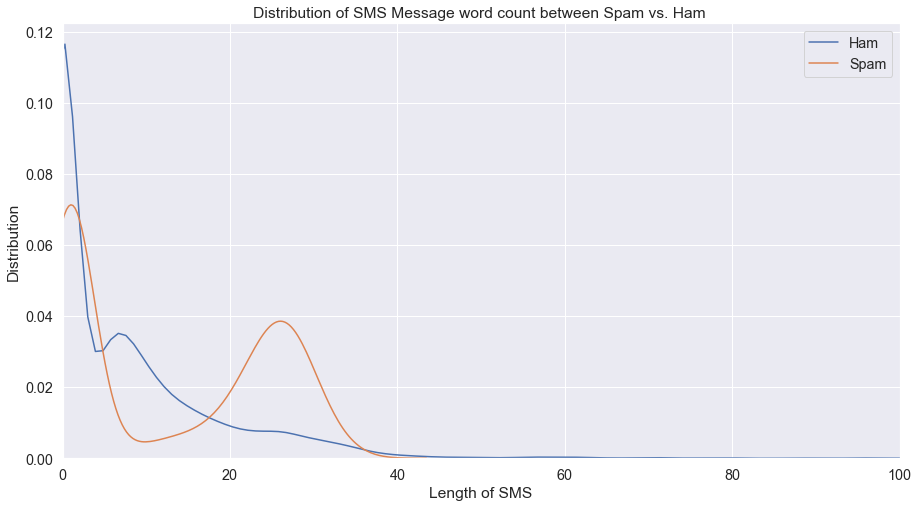

In [18]:
plt.figure(figsize=(15, 8))
hams_length = data[data['IsSpam'] == 0][['IsSpam', 'Word_Count']]
spam_length = data[data['IsSpam'] == 1][['IsSpam', 'Word_Count']]
plt.title('Distribution of SMS Message word count between Spam vs. Ham ')
ax = sns.distplot(hams_length, hist = False, label = 'Ham')
ax = sns.distplot(spam_length, hist = False, label = 'Spam')
plt.xlim(0, 100)
plt.legend()
sns.set(font_scale=1.3)
ax.set_ylabel('Distribution')
ax.set_xlabel('Length of SMS');

Observam ca graficul arata similar cu graficul prezentat mai sus.

In [19]:
data.Length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: Length, dtype: float64

In [20]:
data.Word_Count.describe()

count    5572.000000
mean       15.597452
std        11.404053
min         1.000000
25%         7.000000
50%        12.000000
75%        23.000000
max       171.000000
Name: Word_Count, dtype: float64

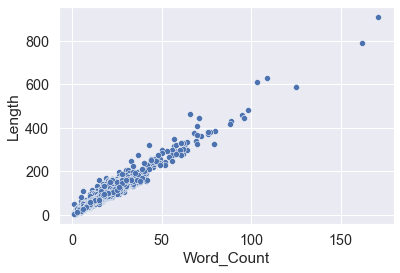

In [21]:
sns.scatterplot(x='Word_Count', y='Length', data=data);

Observam ca numarul de caractere este similar cu numarul de cuvinte din mesaje cu o relatie aproape liniara.

Pentru a evita probleme de coliniaritate, este mai bine daca folosim doar una din cele 2 trasaturi. In consecinta, vom sterge coloana 'Word_Count' din dataframe.

In [22]:
data = data.drop('Word_Count', axis = 1).reset_index(drop=True)
data

,Class,Message,IsSpam,Length
0,ham,"go until jurong point, crazy.. available only ...",0,111
1,ham,ok lar... joking wif u oni...,0,29
2,spam,free entry in 2 a wkly comp to win fa cup fina...,1,155
3,ham,u dun say so early hor... u c already then say...,0,49
4,ham,"nah i don't think he goes to usf, he lives aro...",0,61
...,...,...,...,...
5567,spam,this is the 2nd time we have tried 2 contact u...,1,160
5568,ham,will ü b going to esplanade fr home?,0,36
5569,ham,"pity, * was in mood for that. so...any other s...",0,57
5570,ham,the guy did some bitching but i acted like i'd...,0,125


Vom vedea acum care sunt cuvintele care apar cel mai des in functie de tipul de mesaj.

In [23]:
spam_dictionary = {}
ham_dictionary = {}

def word_count(word, dictionary):
    #cuvinte care vor fi sterse
    remove_words = list(stopwords.words('english')) + ['u', 'ur', '2', '4', 'ü']
    
    #stergerea semnelor de punctuatie
    no_punct = []
    for char in word:
        if char not in string.punctuation:
            no_punct.append(char)
    punctless = ''.join(no_punct)
    
    #stergerea stopword-urilor
    if punctless not in remove_words and punctless != '':
        if punctless in dictionary:
            dictionary[punctless] += 1
        else:
            dictionary[punctless] = 1

ham_list = ' '.join(data[data['IsSpam'] == 0]['Message'].tolist()).split()
spam_list = ' '.join(data[data['IsSpam'] == 1]['Message'].tolist()).split()

for text in ham_list:
    word_count(text, ham_dictionary)

for text in spam_list:
    word_count(text, spam_dictionary)

Vom creea DataFrame-uri pentru numarul de cuvinte si vom selecta cele mai frecvente 10 cuvinte

In [24]:
spam_count = pd.DataFrame(list(spam_dictionary.items()), columns = ['word', 'count']).sort_values(by = 'count', ascending = False).iloc[:10]
ham_count = pd.DataFrame(list(ham_dictionary.items()), columns = ['word', 'count']).sort_values(by = 'count', ascending = False).iloc[:10]

Cele mai frecvente cuvinte din SMS-urile `legitime`:

In [25]:
ham_count[['word']].reset_index(drop=True)

,word
0,im
1,get
2,ltgt
3,ok
4,dont
5,go
6,ill
7,got
8,know
9,call


Cele mai frecvente cuvinte din SMS-urile de tip spam:

In [26]:
spam_count[['word']].reset_index(drop=True)

,word
0,call
1,free
2,txt
3,mobile
4,text
5,stop
6,claim
7,reply
8,prize
9,get


**Observatie** Desi am calculat numarul de aparitii al fiecarui cuvant, acestea nu pot fi utilizate pentru comparatie, deoarece este o diferenta intre numarul de mesaje de tip spam si numarul de mesaje legitime din setul de date. Sunt mult mai multe mesaje legitime decat mesaje de tip spam.

### Curatarea setului de date

Inainte de vectorizarea datelor, este bine sa facem anumite operatii pe aceste date.

In [27]:
def text_cleaning(word):
    #cuvinte care vor fi sterse
    remove_words = list(stopwords.words('english')) + ['u', 'ur', '2', '4', 'ü']
    
    #stergerea semnelor de punctuatie
    no_punct = []
    for char in word:
        if char not in string.punctuation:
            no_punct.append(char)
    punctless = ''.join(no_punct)
    
    #returnam mesajul curat
    return ' '.join([text for text in punctless.split() if text not in remove_words])

data['Cleaned_Message'] = data['Message'].apply(text_cleaning)

In [28]:
data.head()

,Class,Message,IsSpam,Length,Cleaned_Message
0,ham,"go until jurong point, crazy.. available only ...",0,111,go jurong point crazy available bugis n great ...
1,ham,ok lar... joking wif u oni...,0,29,ok lar joking wif oni
2,spam,free entry in 2 a wkly comp to win fa cup fina...,1,155,free entry wkly comp win fa cup final tkts 21s...
3,ham,u dun say so early hor... u c already then say...,0,49,dun say early hor c already say
4,ham,"nah i don't think he goes to usf, he lives aro...",0,61,nah dont think goes usf lives around though


Inlocuim mesajele initiale cu mesajele curatate

In [29]:
data['Message'] = data['Cleaned_Message']
data = data.drop(columns = {'Cleaned_Message'})
data.head()

,Class,Message,IsSpam,Length
0,ham,go jurong point crazy available bugis n great ...,0,111
1,ham,ok lar joking wif oni,0,29
2,spam,free entry wkly comp win fa cup final tkts 21s...,1,155
3,ham,dun say early hor c already say,0,49
4,ham,nah dont think goes usf lives around though,0,61


### Bag of Words

Impartim setul de date in set de antrenare si de testare

In [30]:
X_data = data.drop(columns = ['IsSpam'])
y_data = data['IsSpam']

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=10)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

X_train

,Class,Message,Length
0,spam,500 new mobiles 2004 must go txt nokia 89545 c...,142
1,ham,ok msg b4 leave house,31
2,ham,lets go bill millers,30
3,ham,dont want hear anything,28
4,ham,dont file bagi work called mei tell find anyth...,118
...,...,...,...
3728,ham,day class class,35
3729,ham,time thinkin goin,30
3730,ham,crazy ar hes married like gd looking guys fren...,159
3731,ham,finally came fix ceiling,37


In [31]:
vectorizer = CountVectorizer()

Vom crea un vocabular

In [32]:
document_matrix = vectorizer.fit(X_train['Message'])
len(document_matrix.vocabulary_)

7483

Testam CountVectorizer() pentru unul dintre SMS-uri

In [33]:
train_bow = vectorizer.transform([X_train['Message'][12]])
print(train_bow)
train_bow.shape

  (0, 1462)	1
  (0, 1984)	1
  (0, 6228)	1
  (0, 6504)	1
  (0, 7106)	1
  (0, 7278)	1


(1, 7483)

Folosind `transform`, modelul nostru poate returna o matrice care numara aparitiile fiecarui cuvant. 

Se pare ca in mesajul nostru apar doar 6 cuvinte din totalul de 7483.

Verificam ce cuvant corespunde numarului 6504:

In [34]:
print(vectorizer.get_feature_names()[6504])

text


Verificam si daca mesajul contine cuvantul de mai sus:

In [35]:
X_train['Message'][12]

'text way cup stop work bus'

Aplicam `CountVectorizer()` pe tot setul de date

In [36]:
train_count = vectorizer.transform(X_train['Message'])

In [37]:
print(f'Shape of matrix: {train_count.shape}')
print(f'Amount of Non-Zero occurences: {train_count.nnz}')

Shape of matrix: (3733, 7483)
Amount of Non-Zero occurences: 31638


Returnam matricea Hot-one-encoded

In [38]:
bow_matrix = pd.DataFrame(train_count.toarray(), columns=vectorizer.get_feature_names())
bow_matrix

,008704050406,0089my,0121,01223585334,020603,0207,02070836089,02085076972,020903,021,...,yupz,ywhere,zac,zahers,zealand,zed,zoe,zogtorius,üll,〨ud
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3728,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3729,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3730,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3731,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Term frequency-inverse document frequency (TFIDF)

Desi vectorizarea a venit cu mult mai multe date, o problema este sistemul de weighting. Acum, o celula are valoare 0 sau 1, valori care reprezinta daca acel cuvant apare sau nu. Desi aceasta diferentiere binara este de ajutor, este posibil sa calculam weight-urile acestor valori bazandu-ne pe frecventa de aparitie a cuvantului. Vom folosi pentru acest calcul `TF-IDF`.

In [39]:
tfTransformer = TfidfTransformer().fit(train_count)

Vom testa pe un mesaj pentru a observa output-ul. (Este acelasi mesaj de la testul de CountVectorizer)

In [40]:
tfidf_test = tfTransformer.transform(train_bow)
print(tfidf_test)

  (0, 7278)	0.364275244454683
  (0, 7106)	0.3674442878291312
  (0, 6504)	0.3391348218748505
  (0, 6228)	0.3452554297558748
  (0, 1984)	0.5343371949981742
  (0, 1462)	0.46104041523136147


Putem observa ca in locul valorilor de 0 sau 1, avem acum valori variate in functie de importanta cuvantului.

Aplicam acum `TfidfTransformer` asupra intregului set de date.

In [41]:
train_tfidf = tfTransformer.transform(train_count)

In [42]:
train_tfidf = pd.DataFrame(train_tfidf.toarray(), columns=bow_matrix.columns)
train_tfidf.head()

,008704050406,0089my,0121,01223585334,020603,0207,02070836089,02085076972,020903,021,...,yupz,ywhere,zac,zahers,zealand,zed,zoe,zogtorius,üll,〨ud
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Vom uni acest dataframe cu cel initial, insa vom adauga un sufix pentru ca atat 'Class' cat si 'Message' sunt cuvinte care apar in mesajele noastre si trebuiesc diferentiate.

In [43]:
cleaned_train = X_train.join(train_tfidf, rsuffix='_word', how='left')
cleaned_train

,Class,Message,Length,008704050406,0089my,0121,01223585334,020603,0207,02070836089,...,yupz,ywhere,zac,zahers,zealand,zed,zoe,zogtorius,üll,〨ud
0,spam,500 new mobiles 2004 must go txt nokia 89545 c...,142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ham,ok msg b4 leave house,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ham,lets go bill millers,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ham,dont want hear anything,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ham,dont file bagi work called mei tell find anyth...,118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3728,ham,day class class,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3729,ham,time thinkin goin,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3730,ham,crazy ar hes married like gd looking guys fren...,159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3731,ham,finally came fix ceiling,37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Vom face vectorizarea si tfidf si pentru seturile de testare

In [44]:
test_count = vectorizer.transform(X_test['Message'])
test_tfidf = tfTransformer.transform(test_count)
test_tfidf = pd.DataFrame(test_tfidf.toarray(), columns = bow_matrix.columns)

cleaned_test = X_test.join(test_tfidf, rsuffix='_word', how='left')
cleaned_test

,Class,Message,Length,008704050406,0089my,0121,01223585334,020603,0207,02070836089,...,yupz,ywhere,zac,zahers,zealand,zed,zoe,zogtorius,üll,〨ud
0,ham,wont move morphine,43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ham,hmmbad newshype park plaza 700 studio takenonl...,78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ham,derek done class,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ham,hey happy birthday,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ham,ill hand phone chat wit,36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1834,ham,nothing getting msgs dis name wit different nos,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1835,ham,dont worry easy ingredients,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1836,ham,got back dislikes bed,49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1837,ham,say fantastic chance anything need bigger life...,167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Modele de regresie si de clasificare

Vom crea un dataframe pentru a memora scorurile calculate

In [45]:
column_names = ['model', 'fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1']
scores_df = pd.DataFrame(columns = column_names)

scores_df.head()

,model,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1


Vom renunta la coloanele de tip text

In [46]:
cleaned_train = cleaned_train.drop(columns = ['Class', 'Message'])
cleaned_train

,Length,008704050406,0089my,0121,01223585334,020603,0207,02070836089,02085076972,020903,...,yupz,ywhere,zac,zahers,zealand,zed,zoe,zogtorius,üll,〨ud
0,142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3728,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3729,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3730,159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3731,37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### LogisticRegression

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV

Cautarea valorilor optime ale hiperparametrilor folosind RandomizedSearchCV

In [48]:
regression = LogisticRegression(solver='liblinear', max_iter=1000)
parameter_grid = {'penalty': ['l1', 'l2'], 'C': np.logspace(-4, 4, 20)}
random_search = RandomizedSearchCV(estimator=regression, param_distributions=parameter_grid, cv=5, scoring='neg_mean_squared_error')
random_search.fit(cleaned_train, y_train)
best_parameters = random_search.best_params_

print(best_parameters)

{'penalty': 'l2', 'C': 10000.0}


In [49]:
tunned_regression = LogisticRegression(**best_parameters, solver='liblinear', max_iter=1000)

grid_scores = cross_validate(tunned_regression, cleaned_train, y_train, cv=5, scoring=['accuracy', 'f1'], return_train_score=True)

scores = ['LogisticRegression', grid_scores['fit_time'].mean(), grid_scores['score_time'].mean(), grid_scores['test_accuracy'].mean(),
         grid_scores['train_accuracy'].mean(), grid_scores['test_f1'].mean(), grid_scores['train_f1'].mean()]

for i in range(len(column_names)):
    scores_df.loc[0, column_names[i]] = scores[i]

scores_df.head()

,model,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1
0,LogisticRegression,0.433379,0.056057,0.977766,1.0,0.912522,1.0


#### DecisionTreeClassifier

In [50]:
from sklearn.tree import DecisionTreeClassifier

Cautarea valorilor optime ale hiperparametrilor folosind RandomizedSearchCV

In [51]:
classifier = DecisionTreeClassifier()
parameter_grid = {'max_depth':[3, None], 'max_features':[1, 2, 4, 5, 7], 'min_samples_leaf':[1, 2, 3, 4, 5, 6], 'criterion':['gini', 'entropy']}
    
random_search = RandomizedSearchCV(estimator=classifier, param_distributions=parameter_grid, cv=5, scoring='accuracy')
random_search.fit(cleaned_train, y_train)
best_parameters = random_search.best_params_

print(best_parameters)

{'min_samples_leaf': 1, 'max_features': 7, 'max_depth': 3, 'criterion': 'entropy'}


In [52]:
tunned_classifier = DecisionTreeClassifier(**best_parameters)

grid_scores = cross_validate(tunned_classifier, cleaned_train, y_train, cv=5, scoring=['accuracy', 'f1'], return_train_score=True)

scores = ['DecisionTreeClassifier', grid_scores['fit_time'].mean(), grid_scores['score_time'].mean(), grid_scores['test_accuracy'].mean(),
         grid_scores['train_accuracy'].mean(), grid_scores['test_f1'].mean(), grid_scores['train_f1'].mean()]

for i in range(len(column_names)):
    scores_df.loc[1, column_names[i]] = scores[i]

scores_df.head()

,model,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1
0,LogisticRegression,0.433379,0.056057,0.977766,1.0,0.912522,1.0
1,DecisionTreeClassifier,0.199396,0.058844,0.867398,0.8676,0.027042,0.033201


#### KNeighborsClassifier

In [53]:
from sklearn.neighbors import KNeighborsClassifier

In [54]:
classifier = KNeighborsClassifier()
parameter_grid = {'n_neighbors': list(range(1,10)), 'p': [1, 2]}

random_search = RandomizedSearchCV(estimator=classifier, param_distributions=parameter_grid, cv=5, scoring='accuracy', n_jobs=-1)
random_search.fit(cleaned_train, y_train)
best_parameters = random_search.best_params_

print(best_parameters)

{'p': 2, 'n_neighbors': 3}


In [55]:
tunned_classifer = KNeighborsClassifier(**best_parameters)

grid_scores = cross_validate(tunned_classifier, cleaned_train, y_train, cv=5, scoring=['accuracy', 'f1'], return_train_score=True)

scores = ['KNeighborsClassifier', grid_scores['fit_time'].mean(), grid_scores['score_time'].mean(), grid_scores['test_accuracy'].mean(),
         grid_scores['train_accuracy'].mean(), grid_scores['test_f1'].mean(), grid_scores['train_f1'].mean()]

for i in range(len(column_names)):
    scores_df.loc[2, column_names[i]] = scores[i]

scores_df.head()

,model,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1
0,LogisticRegression,0.433379,0.056057,0.977766,1.0,0.912522,1.0
1,DecisionTreeClassifier,0.199396,0.058844,0.867398,0.8676,0.027042,0.033201
2,KNeighborsClassifier,0.221749,0.06244,0.869813,0.868671,0.058661,0.046788


#### MLP Classifier

In [56]:
from sklearn.neural_network import MLPClassifier

In [57]:
classifier = MLPClassifier(max_iter=100)
parameter_grid = {'hidden_layer_sizes': [(50,50,50), (50, 100, 50), (100,)], 'activation': ['tanh', 'relu'], 'solver': ['sgd', 'adam'],
                 'alpha': [0.0001, 0.05], 'learning_rate': ['constant', 'adaptive']}

random_search = RandomizedSearchCV(estimator=classifier, param_distributions=parameter_grid, cv=5, scoring='accuracy', n_jobs=-1)
random_search.fit(cleaned_train, y_train)
best_parameters = random_search.best_params_

print(best_parameters)

{'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (50, 100, 50), 'alpha': 0.0001, 'activation': 'relu'}


In [58]:
tunned_classifer = MLPClassifier(**best_parameters, max_iter=100)

grid_scores = cross_validate(tunned_classifier, cleaned_train, y_train, cv=5, scoring=['accuracy', 'f1'], return_train_score=True)

scores = ['MLPClassifier', grid_scores['fit_time'].mean(), grid_scores['score_time'].mean(), grid_scores['test_accuracy'].mean(),
         grid_scores['train_accuracy'].mean(), grid_scores['test_f1'].mean(), grid_scores['train_f1'].mean()]

for i in range(len(column_names)):
    scores_df.loc[3, column_names[i]] = scores[i]

scores_df.head()

,model,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1
0,LogisticRegression,0.433379,0.056057,0.977766,1.0,0.912522,1.0
1,DecisionTreeClassifier,0.199396,0.058844,0.867398,0.8676,0.027042,0.033201
2,KNeighborsClassifier,0.221749,0.06244,0.869813,0.868671,0.058661,0.046788
3,MLPClassifier,0.242948,0.067025,0.869545,0.868537,0.055997,0.043364


Vom exporta un fisier html cu rezultatele:

In [59]:
html = scores_df.to_html()
file = open("output/SMSSpamCollection_DataSet.html", "w")
file.write(html)
file.close()

## Setul de date `FarmAds`

### Descrierea setului de date

Aceste date au fost colectate din reclame de tip text gasite pe 12 website-uri care au diferite teme legate de animalele de la ferma. Au fost incluse informatii despre creatorii reclamei si despre pagina unde reclama se afla. Etichetele sunt bazate pe acceptul sau refuzul proprietarului asupra reclamei astfel: 1 este eticheta pentru reclamele acceptate si -1 este eticheta pentru reclamele respinse.

Pentru fiecare reclama, includem cuvintele de la crearea reclamei si cuvintele de pe pagina destinatie. Fiecarui cuvant din partea de creatie ii este atribuit un prefix 'ad-'. Fiecare reclama este pe o linie in fisierul de intrare. Primul cuvant de pe linie este reprezentat de eticheta reclamei.

Setul de date este deja standardizat, fiind efectuate deja stop word removal si stemming. 

De asemenea, exista si o reprezentare bag-of-words in fisierele de intrare. Prima valoare este eticheta, urmata de fiecare atribut nonzero. Toate aceste atribute sunt codate dupa tipul (index:valoare). Totusi, noi vom porni de la fisierul initial si vom incerca sa facem noi toti pasii necesari pentru clasificare.

### Analiza exploratorie a setului de date

In [60]:
def read_file(path):
    file = open(path, "r")
    lines = file.read().splitlines()
    
    words = [lines[i].split() for i in range(len(lines))]
    
    clase = [int(words[i][0]) for i in range(len(words))]
    ads = [' '.join(words[i][1:]) for i in range(len(words))]
    
    data = pd.DataFrame(columns = ['Label', 'Ad'])
    data['Label'] = clase
    data['Ad'] = ads
    
    return data

In [61]:
data = read_file("data/farm-ads")
data.head(10)

,Label,Ad
0,1,ad-jerry ad-bruckheimer ad-chase ad-premier ad...
1,-1,ad-rheumatoid ad-arthritis ad-expert ad-tip ad...
2,-1,ad-rheumatologist ad-anju ad-varghese ad-yonke...
3,-1,ad-siemen ad-water ad-remediation ad-water ad-...
4,-1,ad-symptom ad-muscle ad-weakness ad-genetic ad...
5,1,ad-animal ad-animal ad-wild ad-sa ad-official ...
6,-1,ad-dr ad-enrico ad-fazzini ad-parkinson ad-dis...
7,-1,ad-ulcerative ad-colitis ad-uc ad-quiz ad-ulce...
8,-1,ad-wellcentive ad-registry ad-web ad-base ad-p...
9,1,ad-free ad-raw ad-food ad-video ad-feature ad-...


Exemplificam cum arata o `reclama acceptata`:

In [62]:
data[data['Label'] == 1].iloc[0]['Ad']

'ad-jerry ad-bruckheimer ad-chase ad-premier ad-sept ad-th ad-clip ad-bruckheimer ad-chase page found'

Exemplificam, de asemenea cum arata o `reclama refuzata`:

In [63]:
data[data['Label'] == -1].iloc[0]['Ad']

'ad-rheumatoid ad-arthritis ad-expert ad-tip ad-info ad-article ad-treatment ad-option ad-support title-understand title-rheumatoid title-arthritis title-everyday title-health header-understand header-rheumatoid header-arthritis understand rheumatoid arthritis everyday health root root act consumer root content everyday solution understand rheumatoid arthritis future ra treatment advance rheumatoid arthritis treatment expect future lead researcher ra treatment research exercise ra check tip slideshow help create workout program ra fitness tip question doctor print list rheumatoid arthritis question doctor visit list ra question understand rheumatoid arthritis tip manage rheumatoid arthritis pain mak key change help manage rheumatoid arthritis pain ease joint pain strive eat balance diet help healthy weight sufficient vitamin mineral counter chronic inflammation tip ease rheumatoid arthritis pain cause rheumatoid arthritis inflammation rheumatoid arthritis ra symptom cause inflammation 

Calculam lungimea mesajelor in numar de caractere si adaugam o coloana cu aceasta valoare in dataframe-ul nostru.

In [64]:
data['Char_Length'] = data['Ad'].apply(len)
data

,Label,Ad,Char_Length
0,1,ad-jerry ad-bruckheimer ad-chase ad-premier ad...,100
1,-1,ad-rheumatoid ad-arthritis ad-expert ad-tip ad...,3816
2,-1,ad-rheumatologist ad-anju ad-varghese ad-yonke...,656
3,-1,ad-siemen ad-water ad-remediation ad-water ad-...,1316
4,-1,ad-symptom ad-muscle ad-weakness ad-genetic ad...,106
...,...,...,...
4138,-1,ad-affordable ad-ivf ad-cost ad-efficient ad-i...,1617
4139,1,ad-mozypro ad-business ad-backup ad-affordable...,1524
4140,1,ad-oster ad-line ad-clipper ad-oster ad-factor...,7462
4141,-1,ad-synrevoice ad-schoolconnect ad-trust ad-aut...,1374


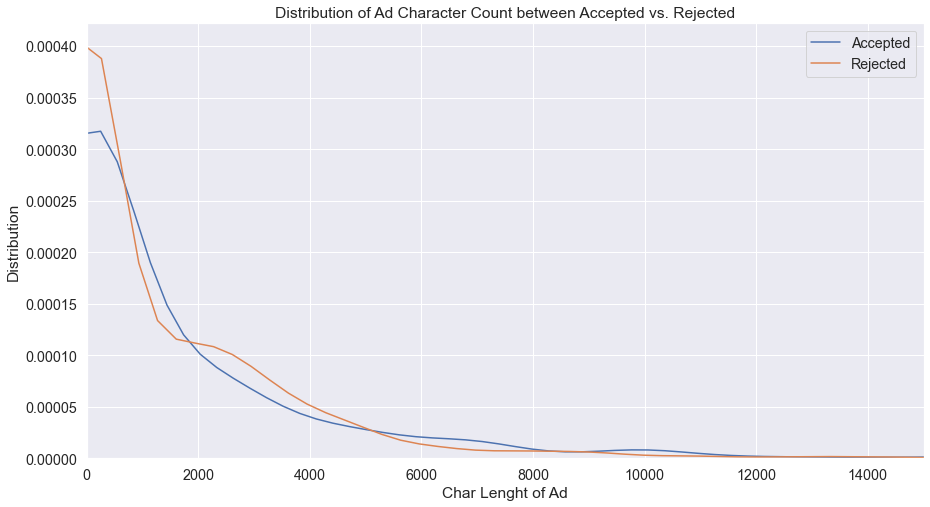

In [65]:
plt.figure(figsize=(15, 8))
good_length = data[data['Label'] == 1][['Label', 'Char_Length']]
bad_length = data[data['Label'] == -1][['Label', 'Char_Length']]
ax = sns.distplot(good_length, hist=False, label = 'Accepted')
ax = sns.distplot(bad_length, hist=False, label = 'Rejected')
plt.xlim(0,15000)
plt.title('Distribution of Ad Character Count between Accepted vs. Rejected')
sns.set(font_scale=1.3)
plt.legend()
ax.set_ylabel('Distribution')
ax.set_xlabel('Char Lenght of Ad');

Afisam date despre reclamele acceptate:

In [66]:
data[data['Label'] == 1].describe()

,Label,Char_Length
count,2210.0,2210.000000
mean,1.0,3483.166968
std,0.0,5608.191154
min,1.0,31.000000
25%,1.0,833.250000
50%,1.0,2049.000000
75%,1.0,4110.000000
max,1.0,54314.000000


Afisam, de asemenea, date despre reclamele refuzate:

In [67]:
data[data['Label'] == -1].describe()

,Label,Char_Length
count,1933.0,1933.000000
mean,-1.0,2918.441800
std,0.0,3756.327081
min,-1.0,34.000000
25%,-1.0,1128.000000
50%,-1.0,2129.000000
75%,-1.0,3538.000000
max,-1.0,63195.000000


Observam ca numarul de caractere este destul de asemanator pentru ambele tipuri de reclame. Vom vedea acum si numarul de cuvinte in functie de tipul reclamei.

In [68]:
data['Word_Count'] = data['Ad'].str.split().str.len()
data

,Label,Ad,Char_Length,Word_Count
0,1,ad-jerry ad-bruckheimer ad-chase ad-premier ad...,100,11
1,-1,ad-rheumatoid ad-arthritis ad-expert ad-tip ad...,3816,498
2,-1,ad-rheumatologist ad-anju ad-varghese ad-yonke...,656,82
3,-1,ad-siemen ad-water ad-remediation ad-water ad-...,1316,159
4,-1,ad-symptom ad-muscle ad-weakness ad-genetic ad...,106,11
...,...,...,...,...
4138,-1,ad-affordable ad-ivf ad-cost ad-efficient ad-i...,1617,191
4139,1,ad-mozypro ad-business ad-backup ad-affordable...,1524,204
4140,1,ad-oster ad-line ad-clipper ad-oster ad-factor...,7462,1139
4141,-1,ad-synrevoice ad-schoolconnect ad-trust ad-aut...,1374,145


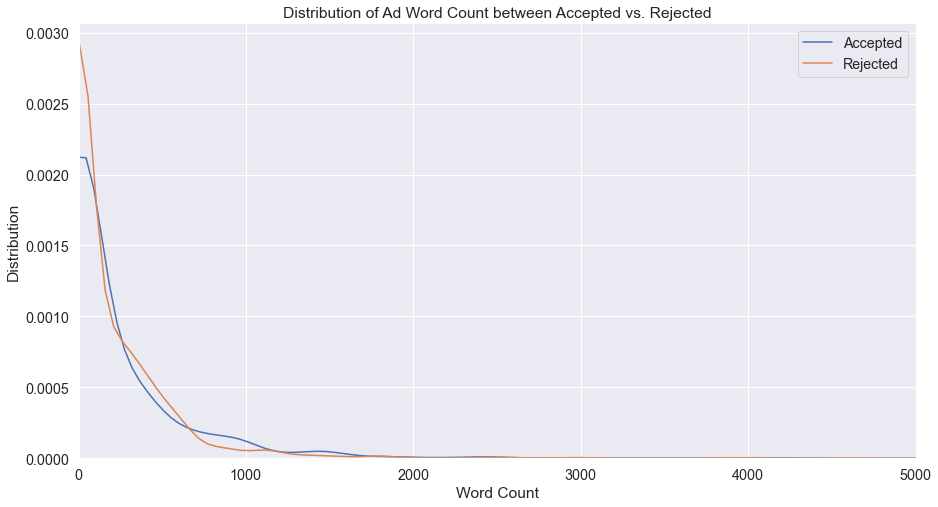

In [69]:
plt.figure(figsize=(15, 8))
good_length = data[data['Label'] == 1][['Label', 'Word_Count']]
bad_length = data[data['Label'] == -1][['Label', 'Word_Count']]
ax = sns.distplot(good_length, hist=False, label = 'Accepted')
ax = sns.distplot(bad_length, hist=False, label = 'Rejected')
plt.xlim(0, 5000)
plt.title('Distribution of Ad Word Count between Accepted vs. Rejected')
sns.set(font_scale=1.3)
plt.legend()
ax.set_ylabel('Distribution')
ax.set_xlabel('Word Count');

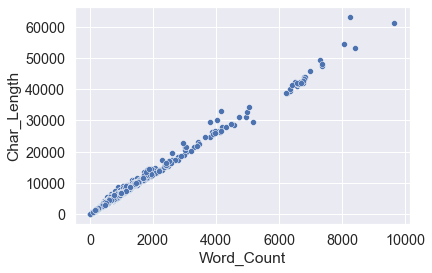

In [72]:
sns.scatterplot(x='Word_Count', y='Char_Length', data=data);

Se poate observa ca numarul de caractere este similar cu numarul de cuvinte, aflandu-se intr-o relatie aproape liniara.

Pentru a evita problemele, este mai bine sa alegem doar una dintre trasaturi. In consecinta, vom sterge din dataframe coloana 'Char_Length'.

In [73]:
data = data.drop('Char_Length', axis=1).reset_index(drop=True)
data

,Label,Ad,Word_Count
0,1,ad-jerry ad-bruckheimer ad-chase ad-premier ad...,11
1,-1,ad-rheumatoid ad-arthritis ad-expert ad-tip ad...,498
2,-1,ad-rheumatologist ad-anju ad-varghese ad-yonke...,82
3,-1,ad-siemen ad-water ad-remediation ad-water ad-...,159
4,-1,ad-symptom ad-muscle ad-weakness ad-genetic ad...,11
...,...,...,...
4138,-1,ad-affordable ad-ivf ad-cost ad-efficient ad-i...,191
4139,1,ad-mozypro ad-business ad-backup ad-affordable...,204
4140,1,ad-oster ad-line ad-clipper ad-oster ad-factor...,1139
4141,-1,ad-synrevoice ad-schoolconnect ad-trust ad-aut...,145


Vom verifica acum care sunt cuvintele care apar cel mai des in functie de tipul reclamei:

In [75]:
good_dictionary = {}
bad_dictionary = {}

def word_count(word, dictionary):
    if word in dictionary:
        dictionary[word] +=1
    else:
        dictionary[word] = 1

good_list = ' '.join(data[data['Label'] == 1]['Ad'].tolist()).split()
bad_list = ' '.join(data[data['Label'] == -1]['Ad'].tolist()).split()

for word in good_list:
    word_count(word, good_dictionary)

for word in bad_list:
    word_count(word, bad_dictionary)

Vom genera DataFrame-uri pentru numarul de cuvinte si vom selecta cele mai frecvente 10 cuvinte

In [78]:
good_count = pd.DataFrame(list(good_dictionary.items()), columns = ['word', 'count']).sort_values(by = 'count', ascending = False).iloc[:10]
bad_count = pd.DataFrame(list(bad_dictionary.items()), columns = ['word', 'count']).sort_values(by = 'count', ascending = False).iloc[:10]

Cuvintele care apar cel mai des in reclamele acceptate sunt:

In [81]:
good_count.head(10).reset_index(drop=True)

,word,count
0,list,19179
1,product,14459
2,com,8444
3,save,7153
4,pet,7015
5,ad,6838
6,name,6601
7,create,6528
8,law,5975
9,please,5959


Cuvintele care apar cel mai des in reclamele refuzate sunt:

In [82]:
bad_count.head(10).reset_index(drop=True)

,word,count
0,disease,6502
1,treatment,5398
2,health,4115
3,home,3625
4,pain,3348
5,com,3323
6,product,3146
7,symptom,3040
8,help,2971
9,information,2832


### Bag of Words

In [83]:
X_data = data.drop(columns = ['Label'])
y_data = data['Label']

In [85]:
vectorizer = CountVectorizer()

In [86]:
document_matrix = vectorizer.fit(X_data['Ad'])
len(document_matrix.vocabulary_)

43602

Testam CountVectorizer() pe una dintre reclame.

In [92]:
train_bow = vectorizer.transform([X_data['Ad'][25]])
print(train_bow)
train_bow.shape

  (0, 234)	1
  (0, 423)	8
  (0, 463)	1
  (0, 620)	1
  (0, 1122)	5
  (0, 1279)	1
  (0, 2493)	5
  (0, 3123)	1
  (0, 3928)	1
  (0, 4441)	5
  (0, 4472)	1
  (0, 5366)	1
  (0, 5838)	1
  (0, 5968)	2
  (0, 6058)	2
  (0, 6065)	2
  (0, 6088)	1
  (0, 6893)	2
  (0, 7088)	1
  (0, 7132)	1
  (0, 8160)	2
  (0, 8339)	1
  (0, 9930)	3
  (0, 10411)	4
  (0, 10873)	2
  :	:
  (0, 28183)	3
  (0, 28462)	1
  (0, 28489)	1
  (0, 28903)	9
  (0, 29648)	12
  (0, 29649)	2
  (0, 29774)	1
  (0, 30144)	1
  (0, 30692)	6
  (0, 31027)	1
  (0, 32535)	4
  (0, 32557)	2
  (0, 35416)	5
  (0, 36299)	1
  (0, 36305)	1
  (0, 37376)	1
  (0, 37385)	17
  (0, 38846)	2
  (0, 38951)	1
  (0, 39100)	3
  (0, 41072)	1
  (0, 41185)	2
  (0, 41338)	1
  (0, 41982)	7
  (0, 42027)	1


(1, 43602)

Folosind `transform`, modelul nostru poate returna o matrice care contine numarul de aparitii ale fiecarui cuvant.

Verificam ce cuvant corespunde numarului 39100.

In [93]:
print(vectorizer.get_feature_names()[39100])

total


Verificam daca reclama contine acest cuvant.

In [94]:
X_data['Ad'][25]

'ad-horse ad-vet ad-buy ad-nutritional ad-supplement ad-horse ad-wellness ad-performance title-equine title-platinumperformance header-equine equine platinumperformance horse dog cat product platinum performance platinum performance cj ortho chon ortho chon ii hemo flo bio sponge skin allergy formula platinum potency category total horse health athletic performance bone density hoof support immune support digestive health joint support metabolic support reproduction fertility skin allergy weight management product platinum pak guide pak pak meet platinum horse platinum platinum platinum advisor platinum partner sponsorship contact log view cart foundation platinum bar athletic performance bone density cardio circulatory support immune support joint support vitamin mineral weight loss product horse total horse health athletic performance bone health hoof support immune health digestive health joint support metabolic support reproduction fertility skin allergy weight management product d

Aplicam `CountVectorizer()` pe tot setul de date.

In [96]:
data_count = vectorizer.transform(X_data['Ad'])

print(f'Shape of matrix: {data_count.shape}')
print(f'Ammount of Non-Zero occurences: {data_count.nnz}')

Shape of matrix: (4143, 43602)
Ammount of Non-Zero occurences: 770770


In [97]:
bow_matrix = pd.DataFrame(data_count.toarray(), columns=vectorizer.get_feature_names())
bow_matrix

,aa,aaa,aaaa,aaaaa,aaaaaaaaadc,aaaaaaaaaew,aaaaaaaaato,aaaaaaaabhc,aaaaaaaagy,aaahc,...,zymine,zymosine,zyprexa,zyrpxqeb,zyrtec,zyvox,zz,zzakhrqaww,zzay,zzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4138,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4139,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4141,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Term frequency-inverse document frequency (TF-IDF)

Desi vectorizarea a venit cu mult mai multe date, o problema este sistemul de weighting. Acum, o celula are valoare 0 sau 1, valori care reprezinta daca acel cuvant apare sau nu. Desi aceasta diferentiere binara este de ajutor, este posibil sa calculam weight-urile acestor valori bazandu-ne pe frecventa de aparitie a cuvantului. Vom folosi pentru acest calcul `TF-IDF`.

In [98]:
tfTransformer = TfidfTransformer().fit(data_count)

Vom testa pe un mesaj pentru a observa outputul. (Este acelasi mesaj de la testul de CountVectorizer)

In [99]:
tfidf_test = tfTransformer.transform(train_bow)
print(tfidf_test)

  (0, 42027)	0.03490600810662302
  (0, 41982)	0.16724171030698215
  (0, 41338)	0.02829699079247972
  (0, 41185)	0.03979917186349144
  (0, 41072)	0.029188487045930453
  (0, 39100)	0.08572974071041288
  (0, 38951)	0.029822621523385575
  (0, 38846)	0.01935988822658524
  (0, 37385)	0.35129228612747526
  (0, 37376)	0.027077326853890485
  (0, 36305)	0.044272534080580725
  (0, 36299)	0.043350917548524624
  (0, 35416)	0.12362102386380905
  (0, 32557)	0.048372461636668876
  (0, 32535)	0.1580203147599707
  (0, 31027)	0.04386523843785264
  (0, 30692)	0.09824215687698772
  (0, 30144)	0.04087917730366812
  (0, 29774)	0.025978913027669897
  (0, 29649)	0.09191904881288819
  (0, 29648)	0.5202110105822955
  (0, 28903)	0.2778539199758509
  (0, 28489)	0.035934109585539505
  (0, 28462)	0.028382041093338254
  (0, 28183)	0.13323829098295656
  :	:
  (0, 10873)	0.048608670457210686
  (0, 10411)	0.12337617977492636
  (0, 9930)	0.1256003021796037
  (0, 8339)	0.017404118430793303
  (0, 8160)	0.026136171314483442

Putem observa ca avem in locul valorilor de 0 sau 1 valori variate in functie de importanta cuvantului.

Aplicam acum `TfidfTransformer` asupra intregului set de date.

In [100]:
data_tfidf = tfTransformer.transform(data_count)

In [102]:
data_tfidf = pd.DataFrame(data_tfidf.toarray(), columns=bow_matrix.columns)
data_tfidf.head()

,aa,aaa,aaaa,aaaaa,aaaaaaaaadc,aaaaaaaaaew,aaaaaaaaato,aaaaaaaabhc,aaaaaaaagy,aaahc,...,zymine,zymosine,zyprexa,zyrpxqeb,zyrtec,zyvox,zz,zzakhrqaww,zzay,zzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Vom uni acest dataframe cu cel initial.

In [103]:
X_ready = X_data.join(data_tfidf, rsuffix='_word', how='left')
X_ready

,Ad,Word_Count,aa,aaa,aaaa,aaaaa,aaaaaaaaadc,aaaaaaaaaew,aaaaaaaaato,aaaaaaaabhc,...,zymine,zymosine,zyprexa,zyrpxqeb,zyrtec,zyvox,zz,zzakhrqaww,zzay,zzz
0,ad-jerry ad-bruckheimer ad-chase ad-premier ad...,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ad-rheumatoid ad-arthritis ad-expert ad-tip ad...,498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ad-rheumatologist ad-anju ad-varghese ad-yonke...,82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ad-siemen ad-water ad-remediation ad-water ad-...,159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ad-symptom ad-muscle ad-weakness ad-genetic ad...,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4138,ad-affordable ad-ivf ad-cost ad-efficient ad-i...,191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4139,ad-mozypro ad-business ad-backup ad-affordable...,204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4140,ad-oster ad-line ad-clipper ad-oster ad-factor...,1139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4141,ad-synrevoice ad-schoolconnect ad-trust ad-aut...,145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Modele de regresie si de clasificare

Vom crea un dataframe pentru a memora scorurile calculate.

In [104]:
column_names = ['model', 'fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1']
scores_df = pd.DataFrame(columns = column_names)

scores_df.head()

,model,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1


In [105]:
X_ready = X_ready.drop(columns = ['Ad'])
X_ready

,Word_Count,aa,aaa,aaaa,aaaaa,aaaaaaaaadc,aaaaaaaaaew,aaaaaaaaato,aaaaaaaabhc,aaaaaaaagy,...,zymine,zymosine,zyprexa,zyrpxqeb,zyrtec,zyvox,zz,zzakhrqaww,zzay,zzz
0,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4138,191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4139,204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4140,1139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4141,145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### LogisticRegression

Cautarea valorilor optime ale hiperparametrilor folosind RandomizedSearchCV

In [107]:
regression = LogisticRegression(solver='liblinear', max_iter=1000)
parameter_grid = {'penalty': ['l1', 'l2'], 'C': np.logspace(-4, 4, 20)}
random_search = RandomizedSearchCV(estimator=regression, param_distributions=parameter_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
random_search.fit(X_ready, y_data)
best_parameters = random_search.best_params_

print(best_parameters)

{'penalty': 'l2', 'C': 11.288378916846883}


In [108]:
tunned_regression = LogisticRegression(**best_parameters, solver='liblinear', max_iter=1000)

grid_scores = cross_validate(tunned_regression, X_ready, y_data, cv=5, scoring=['accuracy', 'f1'], return_train_score=True)

scores = ['LogisticRegression', grid_scores['fit_time'].mean(), grid_scores['score_time'].mean(), grid_scores['test_accuracy'].mean(),
         grid_scores['train_accuracy'].mean(), grid_scores['test_f1'].mean(), grid_scores['train_f1'].mean()]

for i in range(len(column_names)):
    scores_df.loc[0, column_names[i]] = scores[i]

scores_df.head()

,model,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1
0,LogisticRegression,4.458153,0.354482,0.911905,0.986845,0.919107,0.987755


#### DecisionTreeClassifier

In [110]:
classifier = DecisionTreeClassifier()
parameter_grid = {'max_depth':[3, None], 'max_features':[1, 2, 4, 5, 7], 'min_samples_leaf':[1, 2, 3, 4, 5, 6], 'criterion':['gini', 'entropy']}
    
random_search = RandomizedSearchCV(estimator=classifier, param_distributions=parameter_grid, cv=5, scoring='accuracy', n_jobs=-1)
random_search.fit(X_ready, y_data)
best_parameters = random_search.best_params_

print(best_parameters)

{'min_samples_leaf': 1, 'max_features': 4, 'max_depth': None, 'criterion': 'entropy'}


In [111]:
tunned_classifier = DecisionTreeClassifier(**best_parameters)

grid_scores = cross_validate(tunned_classifier, X_ready, y_data, cv=5, scoring=['accuracy', 'f1'], return_train_score=True)

scores = ['DecisionTreeClassifier', grid_scores['fit_time'].mean(), grid_scores['score_time'].mean(), grid_scores['test_accuracy'].mean(),
         grid_scores['train_accuracy'].mean(), grid_scores['test_f1'].mean(), grid_scores['train_f1'].mean()]

for i in range(len(column_names)):
    scores_df.loc[1, column_names[i]] = scores[i]

scores_df.head()

,model,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1
0,LogisticRegression,4.458153,0.354482,0.911905,0.986845,0.919107,0.987755
1,DecisionTreeClassifier,1.303698,0.366262,0.808355,0.998914,0.821981,0.998982


#### KNeighborsClassifier

In [112]:
classifier = KNeighborsClassifier()
parameter_grid = {'n_neighbors': list(range(1,10)), 'p': [1, 2]}

random_search = RandomizedSearchCV(estimator=classifier, param_distributions=parameter_grid, cv=5, scoring='accuracy', n_jobs=-1)
random_search.fit(X_ready, y_data)
best_parameters = random_search.best_params_

print(best_parameters)

{'p': 1, 'n_neighbors': 1}


In [113]:
tunned_classifer = KNeighborsClassifier(**best_parameters)

grid_scores = cross_validate(tunned_classifier, X_ready, y_data, cv=5, scoring=['accuracy', 'f1'], return_train_score=True)

scores = ['KNeighborsClassifier', grid_scores['fit_time'].mean(), grid_scores['score_time'].mean(), grid_scores['test_accuracy'].mean(),
         grid_scores['train_accuracy'].mean(), grid_scores['test_f1'].mean(), grid_scores['train_f1'].mean()]

for i in range(len(column_names)):
    scores_df.loc[2, column_names[i]] = scores[i]

scores_df.head()

,model,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1
0,LogisticRegression,4.458153,0.354482,0.911905,0.986845,0.919107,0.987755
1,DecisionTreeClassifier,1.303698,0.366262,0.808355,0.998914,0.821981,0.998982
2,KNeighborsClassifier,1.296285,0.355544,0.808837,0.998914,0.823009,0.998982


#### MLP Classifier

In [114]:
classifier = MLPClassifier(max_iter=100)
parameter_grid = {'hidden_layer_sizes': [(50,50,50), (50, 100, 50), (100,)], 'activation': ['tanh', 'relu'], 'solver': ['sgd', 'adam'],
                 'alpha': [0.0001, 0.05], 'learning_rate': ['constant', 'adaptive']}

random_search = RandomizedSearchCV(estimator=classifier, param_distributions=parameter_grid, cv=5, scoring='accuracy', n_jobs=-1)
random_search.fit(X_ready, y_data)
best_parameters = random_search.best_params_

print(best_parameters)

{'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (50, 50, 50), 'alpha': 0.0001, 'activation': 'relu'}


**Rularea celulei de mai sus dureaza aproximativ 120 de minute !!!!**

In [115]:
tunned_classifer = MLPClassifier(**best_parameters, max_iter=100)

grid_scores = cross_validate(tunned_classifier, X_ready, y_data, cv=5, scoring=['accuracy', 'f1'], return_train_score=True)

scores = ['MLPClassifier', grid_scores['fit_time'].mean(), grid_scores['score_time'].mean(), grid_scores['test_accuracy'].mean(),
         grid_scores['train_accuracy'].mean(), grid_scores['test_f1'].mean(), grid_scores['train_f1'].mean()]

for i in range(len(column_names)):
    scores_df.loc[3, column_names[i]] = scores[i]

scores_df.head()

,model,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1
0,LogisticRegression,4.458153,0.354482,0.911905,0.986845,0.919107,0.987755
1,DecisionTreeClassifier,1.303698,0.366262,0.808355,0.998914,0.821981,0.998982
2,KNeighborsClassifier,1.296285,0.355544,0.808837,0.998914,0.823009,0.998982
3,MLPClassifier,3.523617,0.968865,0.808347,0.998914,0.82006,0.998982


Vom exporta un fisier html cu rezultatele:

In [116]:
html = scores_df.to_html()
file = open("output/FarmAds_DataSet.html", "w")
file.write(html)
file.close()